# Analyzing random walks on different network structures

In [1]:
import networkx as nx
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from tqdm.notebook import trange, tqdm
from time import time

import seaborn as sns
sns.set()

import os, sys
currentdir = os.path.dirname(os.path.realpath(__name__))
scriptsdir = os.path.dirname(currentdir)+'/scripts'
sys.path.append(scriptsdir)

In [2]:
from distances import dist_1d, dist_2d_lattice, dist_2d_spacial
from random_walks import simple_2d_random_walk, lazy_2d_random_walk

## End-to-end distance of random walk

In [3]:
def end_to_end_distance(G, L, max_steps, max_walks, start_node=(0, 0), 
        use_random_starting_node=False, random_walk_function=simple_2d_random_walk, parallel=True):
    '''
    Average distance between start and end point of random walk for every step until a given max.

    Arguments:
    - G:                        graph, based on a 2d lattice
    - L:                        side length L of the 2d lattice base of G
    - max_steps:                number of steps the random walker takes in total
    - max_walks:                number of walks to simulate and average over
    - start_node:               node to start random walk from, default=(0,0)
    - use_random_starting_node: start on a randomly chosen node, default=False
    - random_walk_function:     function to use for random walk, default=simple_2d_random_walk
    - parallel:                 use parallel computation for separate walks, default=True

    Return:
    - dist_2d_mean: averaged end to end distance fo random walk for every step
    '''
    # check if using parallel computation
    if parallel:
        # seed list to have independent parallel simulations
        seed_list = np.random.permutation(np.arange(0, max_walks)).tolist()
        # list of random walks (dim = (max_walks, max_steps))
        pool = Pool(cpu_count())
        walks = np.array(pool.starmap_async(
            random_walk_function, 
            [(G, L, max_steps, start_node, use_random_starting_node, seed) for seed in seed_list]
            ).get())[:,:,1]
        pool.close()
    else:
        # list of random walks (dim = (max_walks, max_steps))
        walks = np.array([np.array(random_walk_function(
            G, L, max_steps, start_node, use_random_starting_node=use_random_starting_node)
            )[:,0] for _ in range(max_walks)])

    # calculate distances, use factor to rescale if 1d distance is larger L/2, average over multiple walks
    start_nodes_repeat = np.repeat(walks[:, 0], walks.shape[1], axis=0).reshape(walks.shape)
    factor = np.floor(2.*abs(walks-start_nodes_repeat)/L)
    dist_1d = abs(factor*L - abs(walks-start_nodes_repeat))
    dist_2d_mean = np.sqrt( dist_1d[:,:,0]**2. + dist_1d[:,:,1]**2. ).mean(axis=0)

    return dist_2d_mean

### Test on periodic 2d lattice

In [4]:
L = 300
G = nx.grid_2d_graph(L, L, periodic=True)
max_steps = int(1e3)
max_walks = int(2e3)

In [5]:
# compute r_squared = dist_2d_mean**2. for different max_walks
parallel_list = [False, False, False, True, True]
max_walks_list = np.array([1e2, 2e2, 5e2, 1e3, 2e3], dtype=int)

r_sq_list = []
time_list = []
for i, max_walks in enumerate(max_walks_list):
    tic = time()
    r_over_steps = end_to_end_distance(G, L, max_steps, max_walks, use_random_starting_node=False, parallel=parallel_list[i])
    toc = time()
    r_sq_list.append(r_over_steps**2.)
    time_list.append(toc-tic)

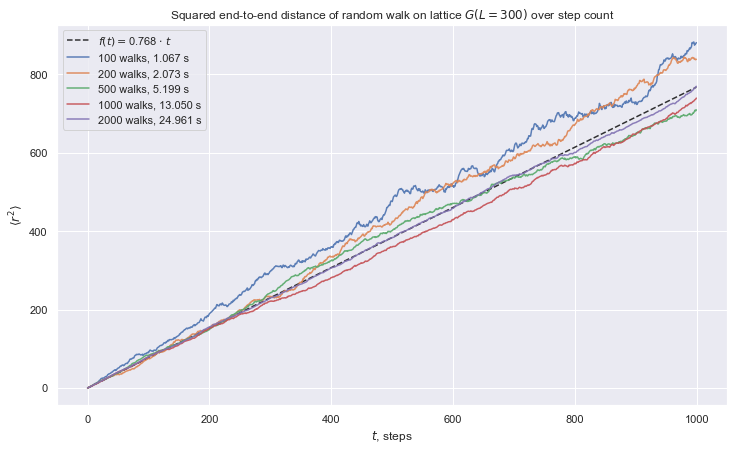

In [6]:
# plot
fig, ax = plt.subplots(figsize=(12,7))
ax.set_title(r'Squared end-to-end distance of random walk on lattice $G(L=300)$ over step count')
ax.plot(np.arange(max_steps), 
    np.mean(np.array(r_sq_list[-1])[1:]/np.arange(1,max_steps)) * np.arange(max_steps),
    alpha=0.8, ls='--', color='black',
    label=r'$f(t)=${:.3f} $\cdot$ $t$'.format(np.mean(np.array(r_sq_list[-1])[1:]/np.arange(1,max_steps))))

for i, r_sq in enumerate(r_sq_list):
    ax.plot(r_sq, alpha=0.9, label='{} walks, {:.3f} s'.format(max_walks_list[i], time_list[i]))

ax.set_ylabel(r'$\langle r^2 \rangle$')
ax.set_xlabel(r'$t$, steps')
ax.legend()
plt.show()

#### Small lattice (lower $L$)

For smaller lattices the diffusion stops at some point because we move closer to the origin again for a periodic lattice. Then $\langle r^2 \rangle$ stops to be linear with $t$, the number of steps.

In [7]:
L = 20
G = nx.grid_2d_graph(L, L, periodic=True)
max_steps = int(1e2)
max_walks = int(1e3)

In [8]:
# compute r_squared = dist_2d_mean**2. for different max_walks
parallel_list = [False, False, True]
max_walks_list = np.array([1e2, 3e2, 1e3], dtype=int)

r_sq_list = []
time_list = []
for i, max_walks in enumerate(max_walks_list):
    tic = time()
    r_over_steps = end_to_end_distance(G, L, max_steps, max_walks, use_random_starting_node=False, parallel=parallel_list[i])
    toc = time()
    r_sq_list.append(r_over_steps**2.)
    time_list.append(toc-tic)

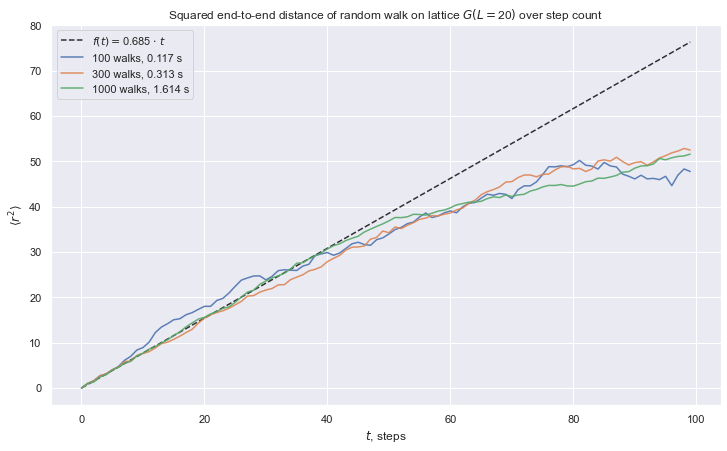

In [9]:
# plot
fig, ax = plt.subplots(figsize=(12,7))
ax.set_title(r'Squared end-to-end distance of random walk on lattice $G(L=${}$)$ over step count'.format(L))
ax.plot(np.arange(max_steps), 
    np.mean(np.array(r_sq_list[-1])[1:int(max_steps/2.)]/np.arange(1,int(max_steps/2.))) * np.arange(max_steps),
    alpha=0.8, ls='--', color='black',
    label=r'$f(t)=${:.3f} $\cdot$ $t$'.format(np.mean(np.array(r_sq_list[-1])[1:]/np.arange(1,max_steps))))

for i, r_sq in enumerate(r_sq_list):
    ax.plot(r_sq, alpha=0.9, label='{} walks, {:.3f} s'.format(max_walks_list[i], time_list[i]))

ax.set_ylabel(r'$\langle r^2 \rangle$')
ax.set_xlabel(r'$t$, steps')
ax.legend()
plt.show()

## Small world networks

### Graph generating functions

In [10]:
from generate_graph import Kleinberg_2d, small_world_2d, small_world_2d_new

#### Note

The time to generate a small world graph is actually approximately $\propto L^4$, with $L$ the lattice side length. E.g. generating $G(L=100, r)$ takes more than $2$ minutes, for $L=200$ we would already be at $32$ minutes. This becomes problematic when we do analysis for different $r$ and need to build multiple graphs, maybe even with increasing $L$ to check the dependence of observables on the underlying lattice size.

In [11]:
# measure times over L for improved small world graph function
t_list = []
L_list = [1, 10, 20, 30, 40, 60, 80, 100]
for L_i in tqdm(L_list):
    tic = time()
    _ = small_world_2d_new(
        L=L_i,
        r=1.)
    toc = time()
    t_list.append(toc-tic)

# measure times over L for first small world graph function
t2_list = []
L2_list = [1, 10, 20, 30, 40, 50, 60, 70]
for L_i in tqdm(L2_list):
    tic = time()
    _ = small_world_2d(
        L=L_i,
        r=1.)
    toc = time()
    t2_list.append(toc-tic)

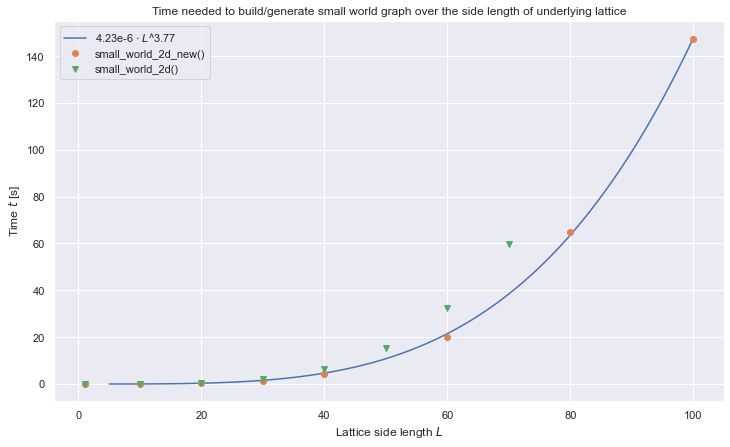

In [12]:
from scipy import optimize

def x_pow(x, a, b):
    return a*x**b


# fit to check dependence  t=a*L^b
popt, _ = optimize.curve_fit(x_pow, np.array(L_list), np.array(t_list))

# plot time t over lattice side length L for the two small world graph functions
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(np.linspace(5, 100, 80), x_pow(np.linspace(5, 100, 80), *popt), label=r'{:.2f}e-6 $\cdot$ $L$^{:.2f}'.format(popt[0]*10**6, popt[1]))
ax.plot(L_list, t_list, marker='o', lw=0, label='small_world_2d_new()')
ax.plot(L2_list, t2_list, marker='v', lw=0, label='small_world_2d()')

ax.set_title('Time needed to build/generate small world graph over the side length of underlying lattice')
ax.set_ylabel(r'Time $t$ [s]')
ax.set_xlabel(r'Lattice side length $L$')
ax.legend()

plt.show()

### Analysis

#### End-to-end distance $\langle r^2\rangle$ for different ```max_walks```

In [13]:
# make small world graph
np.random.seed(42)
L_small_world = 80
r_small_world = 2.
G_small_world = small_world_2d_new(
    L=L_small_world,
    r=r_small_world)

In [14]:
# compute r_squared = dist_2d_mean**2. for different max_walks
parallel_list = [False, False, True, True]
max_steps = int(1e2)
max_walks_list = np.array([1e2, 1e3, 5e3, 1e4], dtype=int)

r_sq_list = []
time_list = []
for i, max_walks in tqdm(enumerate(max_walks_list), total=len(max_walks_list)):
    tic = time()
    r_over_steps = end_to_end_distance(
        G=G_small_world, L=L_small_world, 
        max_steps=max_steps, max_walks=max_walks, 
        use_random_starting_node=False, 
        parallel=parallel_list[i])
    toc = time()
    r_sq_list.append(r_over_steps**2.)
    time_list.append(toc-tic)

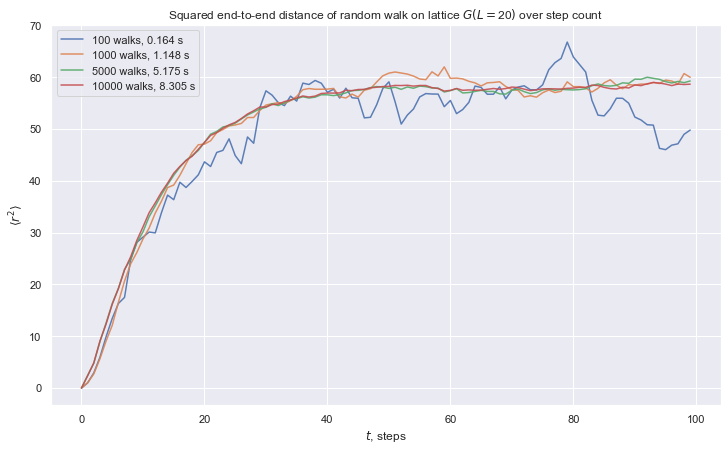

In [16]:
# plot
fig, ax = plt.subplots(figsize=(12,7))
ax.set_title(r'Squared end-to-end distance of random walk on lattice $G(L=${}$)$ over step count'.format(L_small_world))
for i, r_sq in enumerate(r_sq_list):
    #ax.plot(np.sqrt(r_sq), alpha=0.9, label='{} walks, {:.3f} s'.format(max_walks_list[i], time_list[i]))
    ax.plot(r_sq, alpha=0.9, label='{} walks, {:.3f} s'.format(max_walks_list[i], time_list[i]))

ax.set_ylabel(r'$\langle r^2 \rangle$')
ax.set_xlabel(r'$t$, steps')
#ax.loglog()
ax.legend()
plt.show()

#### End-to-end distance $\langle r^2\rangle$ for different $r$ values in $G(L, r)$

In [17]:
L_small_world = 40
r_small_world_list = [0.5, 1., 1.5, 2., 2.5, 3., 3.5, 5.]

max_steps = int(2e2)
max_walks = int(3e3)

r_sq_list = []

for r_i in r_small_world_list:
    # make graph
    G_small_world = small_world_2d_new(
        L=L_small_world, 
        r=r_i,
        seed=i)
    # compute r^2
    r_over_steps = end_to_end_distance(
        G=G_small_world, L=L_small_world, 
        max_steps=max_steps, max_walks=max_walks, 
        use_random_starting_node=False, 
        parallel=True)
    # save r^2
    r_sq_list.append(r_over_steps**2.)

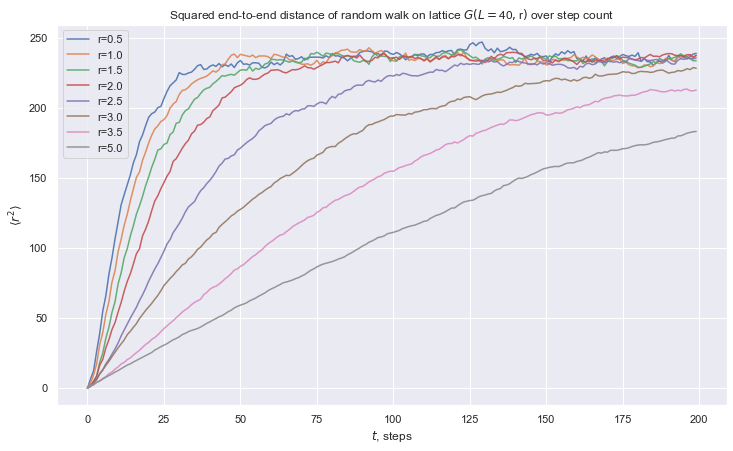

In [19]:
# plot
fig, ax = plt.subplots(figsize=(12,7))
ax.set_title(r'Squared end-to-end distance of random walk on lattice $G(L=${}$, $r$)$ over step count'.format(L_small_world))
for i, r_sq in enumerate(r_sq_list):
    #ax.plot(np.sqrt(r_sq), alpha=0.9, label=r'$r = ${}'.format(r_small_world_list[i]))
    ax.plot(r_sq, alpha=0.9, label='r={}'.format(r_small_world_list[i]))

ax.set_ylabel(r'$\langle r^2 \rangle$')
ax.set_xlabel(r'$t$, steps')
ax.legend()
plt.show()